<a href="https://colab.research.google.com/github/mail2rathina/Rathina/blob/main/music_genre_identification_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import os
import pandas as pd
from glob import glob
import numpy as np

In [2]:
!pip install memory_profiler

In [3]:
%%capture
!apt-get install libav-tools -y

In [4]:
import librosa
import librosa.display
import pylab

In [5]:
import gc
!pip install path

In [6]:
from path import Path
from sklearn.metrics import mean_squared_error
from matplotlib import figure
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

In [7]:
!pip install keras

In [8]:
!wget https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0

--2023-07-07 08:38:36--  https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/4jw31k5mlzcmgis/genres.tar.gz [following]
--2023-07-07 08:38:36--  https://www.dropbox.com/s/raw/4jw31k5mlzcmgis/genres.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc41be7de39ca2d5d6737f0a5985.dl.dropboxusercontent.com/cd/0/inline/B_ZomM5yAIFwZzfAw9dyPdDvQK8Uqt7v7_W2pT3s5lGZfiQnneeLkv8u3hfq5MAKcWOV1Yii8dxQqIDhOHq1-LFN0ttHciHhl9XNCvL4GcOZvsckds9RWRXXcwNheds_Np30OSpmL36G-6-HNHkeHRwIAa1FW6hgfbmtH5fAOoiNzA/file# [following]
--2023-07-07 08:38:37--  https://uc41be7de39ca2d5d6737f0a5985.dl.dropboxusercontent.com/cd/0/inline/B_ZomM5yAIFwZzfAw9dyPdDvQK8Uqt7v7_W2pT3s5lGZfiQnneeLkv8u3hfq5MAKcWOV1Yii

In [9]:
import tarfile



In [10]:
data1 = tarfile.open("genres.tar.gz?dl=0")

In [11]:
data1.extractall('./Audiodata')

In [12]:
data1.close()

In [13]:
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import pathlib
#Keras
import keras

import warnings
warnings.filterwarnings('ignore')


In [14]:
import os
os.mkdir('train')
os.mkdir('test')

In [15]:
glob('./train/*')

[]

In [16]:

file_list=list(glob("./Audiodata/genres/blues/*"))

In [17]:
genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [18]:
audio_fpath = "/content/Audiodata/genres/blues/"
audio_clips = os.listdir(audio_fpath)


print("Number of .wav files in audio folder = ",len(audio_clips))

Number of .wav files in audio folder =  100


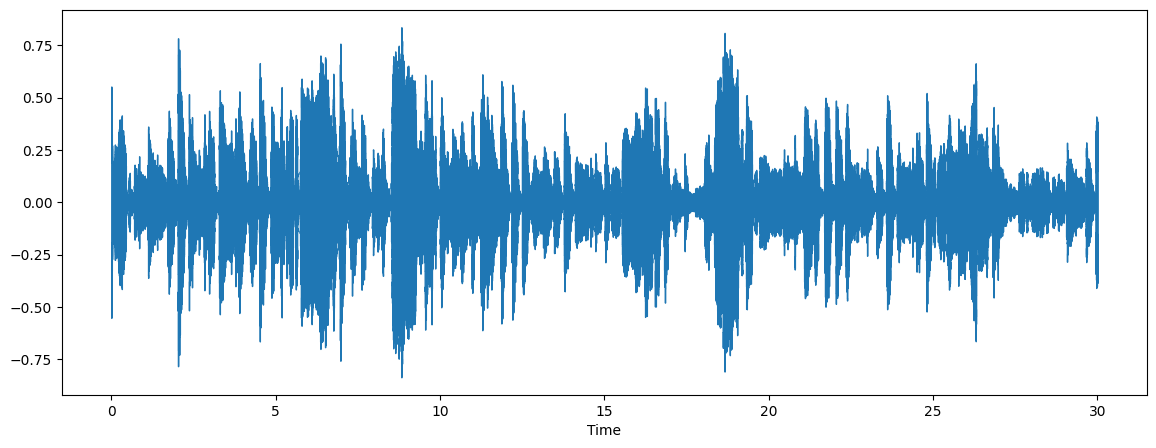

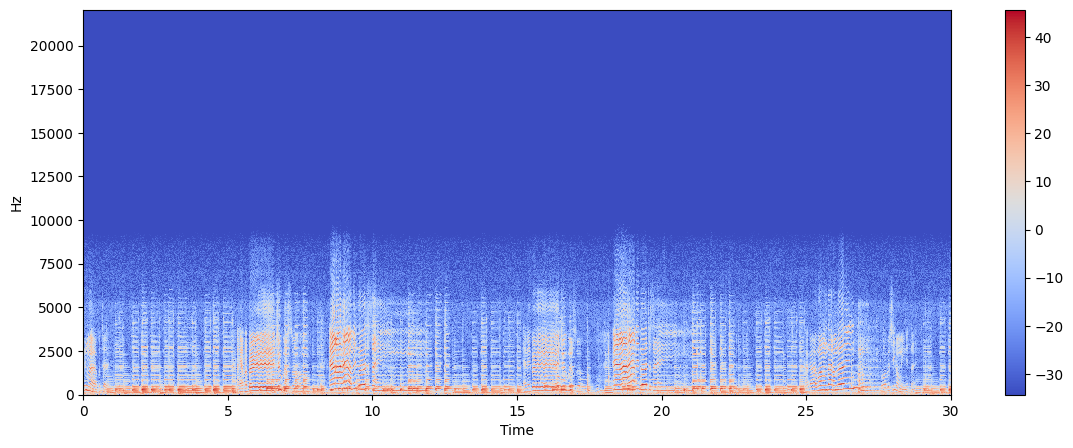

In [19]:
x, sr = librosa.load(audio_fpath+audio_clips[2], sr=44100)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [20]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()


In [21]:
import csv
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./Audiodata/genres/{g}'):
        songname = f'./Audiodata/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
data = pd.read_csv('data.csv')
data = data.drop(['filename'],axis=1)
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.396301,0.235093,2061.202742,2085.186747,4221.307808,0.113397,-38.994843,112.038254,-31.817707,38.240677,...,13.326929,-10.922001,9.794659,-5.032709,7.201395,-6.755035,2.663087,-4.382442,0.414511,blues
1,0.421534,0.270748,2443.238916,2358.384492,5267.559814,0.124735,-3.559072,92.927788,-25.118544,45.187210,...,14.751648,-15.609780,9.549894,-14.798732,2.074836,-13.824648,3.571470,-5.971642,-1.647439,blues
2,0.280721,0.101915,1210.457126,1498.054609,2522.543080,0.052483,-227.268860,137.730698,-14.493466,63.555702,...,-9.429529,-10.923911,3.562557,4.137706,0.095544,-2.972545,-1.378875,7.541176,-3.037463,blues
3,0.274014,0.081321,1817.529547,1973.690309,3944.584481,0.079215,-213.204529,115.154541,-11.720503,39.032555,...,3.786368,0.223687,-5.114481,-0.414537,-1.184898,-1.918339,-2.295796,2.891230,-4.234534,blues
4,0.306442,0.113431,1156.202363,1497.758884,2170.511875,0.058613,-233.857513,136.172089,3.271318,48.931213,...,-2.231880,3.964033,5.318362,0.812266,-1.097914,-4.539752,-2.434786,3.313449,-0.614279,blues


In [23]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
print(y)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [24]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
len(y_train)

800

In [27]:
len(y_test)

200

In [28]:

X_train[10]

array([ 0.41173848,  1.78642024,  1.79657629,  1.69111913,  1.82500152,
        1.82028567,  1.57750279, -1.32079491,  0.30992823, -1.87794442,
        0.75484193, -1.27699932,  0.92964855, -0.75162789,  1.36367873,
       -0.52232681,  0.80960743, -0.30537363,  1.08284474,  0.07810872,
        1.19274917, -0.28878538,  0.73694004,  0.06401173,  0.8166472 ,
        0.81311969])

In [29]:
from tensorflow.keras.layers import Dense, Activation
model_ann = models.Sequential()
model_ann.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(layers.Dense(128, activation='relu'))
model_ann.add(layers.Dense(64, activation='relu'))
model_ann.add(layers.Dense(10, activation='softmax'))
X_train.shape[1]


26

In [30]:
model_ann.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [31]:
print("Fit model on training data")
history = model_ann.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=20
)

Fit model on training data
Epoch 1/20
7/7 [==============================] - 1s 3ms/step - loss: 2.1203 - accuracy: 0.2450
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 1.7989 - accuracy: 0.3375
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 1.6025 - accuracy: 0.3837
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 1.4466 - accuracy: 0.4975
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 1.3046 - accuracy: 0.5550
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 1.1983 - accuracy: 0.5825
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 1.1107 - accuracy: 0.6187
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 1.0437 - accuracy: 0.6375
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.9729 - accuracy: 0.6737
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.9049 - accuracy: 0.6913
Epoch 11/20


In [32]:
test_loss, test_acc = model_ann.evaluate(X_test,y_test)

7/7 [==============================] - 0s 2ms/step - loss: 1.0268 - accuracy: 0.6300


In [33]:

print('test_acc: ',test_acc)

test_acc:  0.6299999952316284


In [34]:

x_val = X_train[:200]
partial_x_train = X_train[200:]

y_val = y_train[:200]
partial_y_train = y_train[200:]

In [35]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=30,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(X_test, y_test)

Epoch 1/30
2/2 [==============================] - 1s 138ms/step - loss: 2.3142 - accuracy: 0.0883 - val_loss: 2.1332 - val_accuracy: 0.3350
Epoch 2/30
2/2 [==============================] - 0s 25ms/step - loss: 2.0915 - accuracy: 0.3667 - val_loss: 1.9826 - val_accuracy: 0.4000
Epoch 3/30
2/2 [==============================] - 0s 43ms/step - loss: 1.9169 - accuracy: 0.3800 - val_loss: 1.8583 - val_accuracy: 0.4150
Epoch 4/30
2/2 [==============================] - 0s 26ms/step - loss: 1.7706 - accuracy: 0.3833 - val_loss: 1.7631 - val_accuracy: 0.4200
Epoch 5/30
2/2 [==============================] - 0s 31ms/step - loss: 1.6637 - accuracy: 0.3967 - val_loss: 1.6501 - val_accuracy: 0.4050
Epoch 6/30
2/2 [==============================] - 0s 42ms/step - loss: 1.5585 - accuracy: 0.4350 - val_loss: 1.5431 - val_accuracy: 0.4350
Epoch 7/30
2/2 [==============================] - 0s 28ms/step - loss: 1.4699 - accuracy: 0.4983 - val_loss: 1.4638 - val_accuracy: 0.4950
Epoch 8/30
2/2 [==========

In [36]:
results


[1.1119738817214966, 0.6100000143051147]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
predictions = model.predict(X_test)


In [ ]:
predictions[0].shape

In [ ]:

np.sum(predictions[0])

In [ ]:
np.argmax(predictions[0])

In [ ]:
predict_prob=model.predict([X_test])

predict_classes=np.argmax(predict_prob,axis=1)

In [ ]:
accuracy_score=(y_test, predict_classes)

In [ ]:
accuracy_score